## Improving the secretion score of a protein

In [10]:
import os, sys

In [11]:
import lmpm

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pandas as pd
import seaborn as sns

#to remove
import pickle
import os
current_wd = '/home/mexposit/LMPM/lmpm'
from lmpm.unirep import get_UniReps
from lmpm import localization_score


# in the module, use:
# from .predict import localization_score

In [13]:
amino_acids = ['G', 'A', 'L', 'M', 'F',
               'W', 'K', 'Q', 'E', 'S',
               'P', 'V', 'I', 'C', 'Y',
               'H', 'R', 'N', 'D', 'T']

In [14]:
seq = 'GALRNDTGALMFWK'
org = 'ecoli'
target = 'membrane'

1. get the predicted class and probability at which the sequence belongs to -> Do I really need to do it if we already did that?
2. define a target class you want to optimize for
3. take in a list of positions to mutate if desired

In [15]:
seq[:3]+str('A')+seq[3+1:]

'GALANDTGALMFWK'

In [16]:
positions = ['1-3','4','7-9']

In [17]:
positions = "1-3,4,7-9"

In [18]:
get_residue_positions(positions)

array([1, 2, 3, 4, 7, 8, 9])

In [19]:
def get_residue_positions(positions):
    """Converts a list of integers or range of residues to individual residue numbers.
    
    Args:
        positions: list of protein residues as integers or ranges.
            Example: [1,3-5,8]
            
    Returns:
        res_posit: list of individual residues.
            Example: [1,3,4,5,8]
    """
    
    # initialize list
    res_posit = np.array([])
    
    # preprocess array to get as list
    positions = positions.split(',')
    
    for item in positions:
        # raise eerror if it is not a string or it will return an error!
        # split if contains a "-"
        item = np.array(item.split('-'), dtype='int')
        # if it contains a "-" the length will be 2
        if len(item) == 2:
            # create a range of integers from lower to higher value
            res_posit = np.append(res_posit, list(range(item[0], item[1]+1)))
        elif len(item) == 1:
            res_posit = np.append(res_posit, item)
        else:
            raise ValueError('The position should be a list of integers or ranges defined as: "integer-integer"')
    
    res_posit = np.array(np.unique(np.sort(res_posit)), dtype='int')
    
    return res_posit

In [20]:
# wrapper function
def optimize_sequence(sequence, organism, target_class, include_dg=False, positions=None):
    """
    
    """
    # First, find the initial class and initial secretion score for that class
    initial_class, initial_score = localization_score(sequence, organism, target_class, include_dg)
    # Also find the probability of being from the target_class
#     print('The initial sequence is:', sequence)
#     print('The initial localization clas is:', initial_class)
#     print('The initial probability of being in the secreted class is:', 
#         initial_score)
    
    # set a maximum of positions with time and plot maximum considerations
    
    
    # if no position was specified mutate all
    if positions == None:
        res_poses = np.array(list(range(0,len(sequence))))
    else:
        # create test to check if position is a list
        res_poses = get_residue_positions(positions)
        # inform user that positions are 1 based so that they can usually work on that from a pdb file
        # convert positions to 0 based positions
        res_poses = res_poses - 1
        
        # check if largest position is within the protein length
        if np.max(res_poses)+1 > len(sequence):
            raise ValueError('You passed residue position '+str(np.max(res_poses)+1)+', which is larger than the protein length of '+str(len(sequence))+' residues.')
        else:
            pass

    mutated_scores = pd.DataFrame()
    
    for resid in res_poses:
#         print("running position", resid, "of", str(np.max(res_poses)))
        
        mut_score_pos = []
        
        for mutation in amino_acids:
            mutated_seq = sequence[:resid] + str(mutation) + sequence[resid+1:]
#             pred_score = 3
            pred_class, pred_score = localization_score(mutated_seq, organism, target_class, include_dg)
            mut_score_pos.append(pred_score)
        
        mut_score_pos = pd.Series(mut_score_pos, index = amino_acids)
        
        original_name = str(sequence[resid]) + '_' + str(resid)
        
        mutated_scores[original_name] = mut_score_pos

    
    
    return mutated_scores, initial_score

In [24]:
dats = optimize_sequence(seq, org, target, positions='1,3')

In [29]:
dats = dats[0]

In [30]:
initial_class, initial_score = localization_score(seq, org, target)
#     print('The initial sequence is:', sequence)
print('The initial localization clas is:', initial_class)
print('The initial probability of being in the secreted class is:', 
        initial_score)

The initial localization clas is: cytoplasm
The initial probability of being in the secreted class is: 0.4


In [31]:
dats-initial_score

,G_0,L_2
G,0.00,-0.03
A,-0.03,0.00
L,-0.07,0.00
M,-0.05,-0.04
F,-0.06,0.00
W,0.01,-0.04
K,0.03,-0.04
Q,0.01,0.00
E,0.03,-0.01
S,0.02,0.05


In [32]:
data2 = dats.copy()
for i in range(0,20):
    data2[str(i)+'a'] = dats['G_0']
    data2[str(i)+'b'] = dats['L_2']

In [33]:
import matplotlib.ticker as mticker

In [115]:
# this one is functional!!
def plot_optimization(mutated_scores, initial_score):
    
    relative_sc = mutated_scores - initial_score
    max_sc = np.max(np.abs(relative_sc.values))
    
    fig, ax = plt.subplots(1, 1, figsize=(8*relative_sc.shape[1]/28,6))

    pcm = ax.pcolormesh(mutated_scores.columns, mutated_scores.index,
                        relative_sc.values, shading='nearest',
                        norm=colors.Normalize(vmin=-max_sc, vmax=max_sc),
                        cmap='bwr')
    cb = fig.colorbar(pcm, ax=ax, extend='both')
    cb.set_label('Change in probability for target class',  fontsize=12)
    # ax.set_xticklabels(labels, rotation=45, ha='right')
    # ax.set_xticklabels(ax.get_xticks(), rotation=90)
    ax.set_xticklabels(mutated_scores.columns, rotation=90)
    
    # to try to remove warning
#     ticks_loc = mutated_scores.columns.tolist()
#     ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#     ax.set_xticklabels([x for x in ticks_loc])


    plt.show()
    return None

<ipython-input-115-527c774db907>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


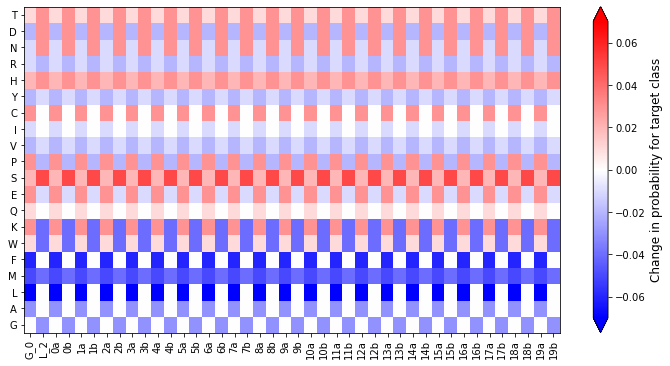

In [116]:
plot_optimization(data2, initial_score)

In [36]:
# better shape hopefully
def plot_optimization(mutated_scores, initial_score):
    
    relative_sc = mutated_scores - initial_score
    # set width between 8 and 18 depending on number of positions
    # if the maximum is passed, the x axis labels will overlap
    width = np.minimum(np.maximum(int(8*mutated_scores.shape[1]/28),8),18)
    # to have 0 centered color bar get maximum value in dataset
    max_sc = np.max(np.abs(relative_sc.values))
    
    fig, ax = plt.subplots(1, 1, figsize=(width,6))

    pcm = ax.pcolormesh(mutated_scores.columns, mutated_scores.index,
                        relative_sc.values, shading='nearest',
                        norm=colors.Normalize(vmin=-max_sc, vmax=max_sc),
                        cmap='bwr')
    fig.colorbar(pcm, ax=ax, extend='both')
    # ax.set_xticklabels(labels, rotation=45, ha='right')
    # ax.set_xticklabels(ax.get_xticks(), rotation=90)
    ax.set_xticklabels(mutated_scores.columns, rotation=90)
    
    # to try to remove warning
#     ticks_loc = mutated_scores.columns.tolist()
#     ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#     ax.set_xticklabels([x for x in ticks_loc])
    ax.set_xlabel('Position and original amino acid')
    ax.set_ylabel('Mutation')

    plt.show()
    return None

### How would the heatmap look like with more data?

In [ ]:
plot_optimization(dats, initial_score)

In [118]:
data3 = dats.copy()
for i in range(0,10):
    data3[str(i)+'a'] = dats['G_0']
    data3[str(i)+'b'] = dats['L_2']

In [119]:
data4 = dats.copy()
for i in range(0,30):
    data4[str(i)+'a'] = dats['G_0']
    data4[str(i)+'b'] = dats['L_2']

In [120]:
data5 = dats.copy()
for i in range(0,8):
    data5[str(i)+'a'] = dats['G_0']
    data5[str(i)+'b'] = dats['L_2']

In [121]:
data6 = dats.copy()
for i in range(0,40):
    data6[str(i)+'a'] = dats['G_0']
    data6[str(i)+'b'] = dats['L_2']

<ipython-input-115-527c774db907>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


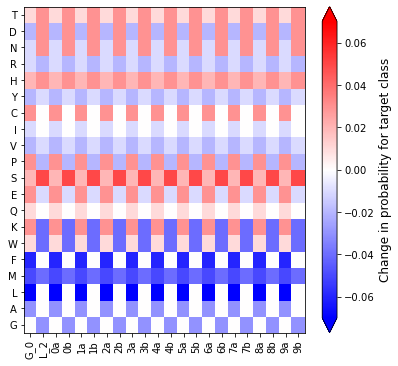

In [122]:
plot_optimization(data3, initial_score)

<ipython-input-189-94aaf25db387>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


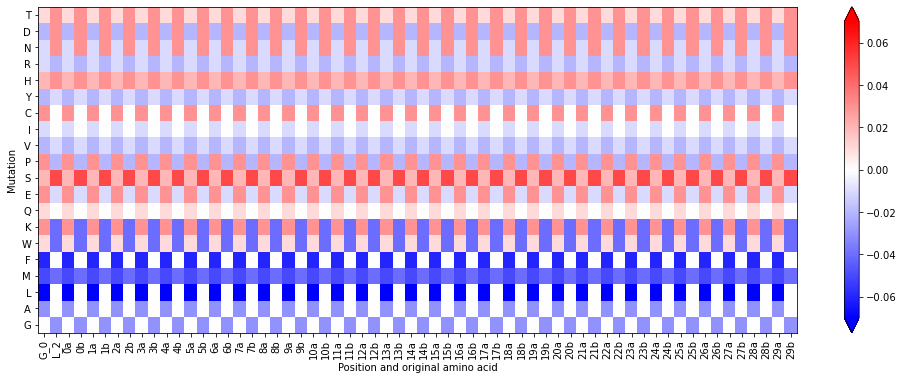

In [195]:
plot_optimization(data4, initial_score)

<ipython-input-189-94aaf25db387>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


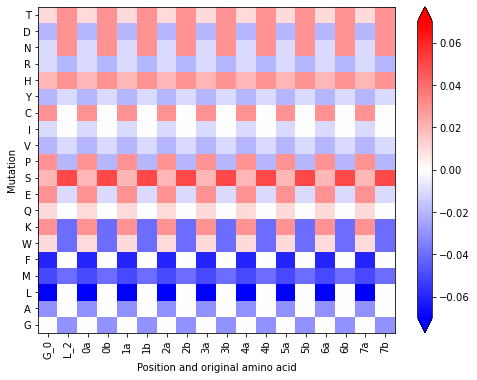

In [196]:
plot_optimization(data5, initial_score)

<ipython-input-197-8f71d4323030>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


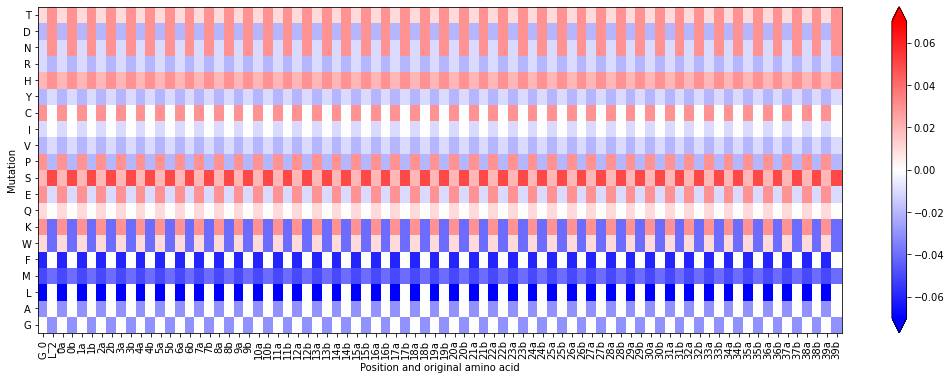

In [199]:
# maximum width but still without overlap
plot_optimization(data6, initial_score)

In [37]:
def plot_optimization(mutated_scores, initial_score, plot_inplace=True, dpi=100):
    """

    """
    if not isinstance(mutated_scores, pd.DataFrame):
        raise TypeError('The mutate_scores variable should be a pd.DataFrame object but received a '+str(type(mutated_scores)))
    else:
        pass

    try:
        relative_sc = mutated_scores - initial_score
    except Exception as e:
        raise TypeError('The values of the mutated scores dataframe and initial_score variable should be numeric. But got error: '+str(e))
    
    try:
        dpi = int(dpi)
    except Exception as e:
        raise TypeError('The value of dpi should be an integer, but got '+str(dpi)+' instead')

    # set width between 8 and 18 depending on number of positions
    # if the maximum is passed, the x axis labels will overlap
    width = np.minimum(np.maximum(int(8*mutated_scores.shape[1]/28),8),18)
    # to have 0 centered color bar get maximum value in dataset
    max_sc = np.max(np.abs(relative_sc.values))
    
    fig, ax = plt.subplots(1, 1, figsize=(width,6), dpi=dpi)

    pcm = ax.pcolormesh(mutated_scores.columns, mutated_scores.index,
                        relative_sc.values, shading='nearest',
                        norm=colors.Normalize(vmin=-max_sc, vmax=max_sc),
                        cmap='bwr')
    fig.colorbar(pcm, ax=ax, extend='both')
    # ax.set_xticklabels(labels, rotation=45, ha='right')
    # ax.set_xticklabels(ax.get_xticks(), rotation=90)
    ax.set_xticklabels(mutated_scores.columns, rotation=90)
    
    # to try to remove warning
#     ticks_loc = mutated_scores.columns.tolist()
#     ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
#     ax.set_xticklabels([x for x in ticks_loc])
    ax.set_xlabel('Position and original amino acid')
    ax.set_ylabel('Mutation')

    # if on a notebook, plot and return nothing or it would be plot twice 
    if plot_inplace:
        plt.show()
        return None
    # for other applications select plot_inplace=False and return the figure
    else:
        return fig

<ipython-input-37-fa827ba5b8f3>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(mutated_scores.columns, rotation=90)


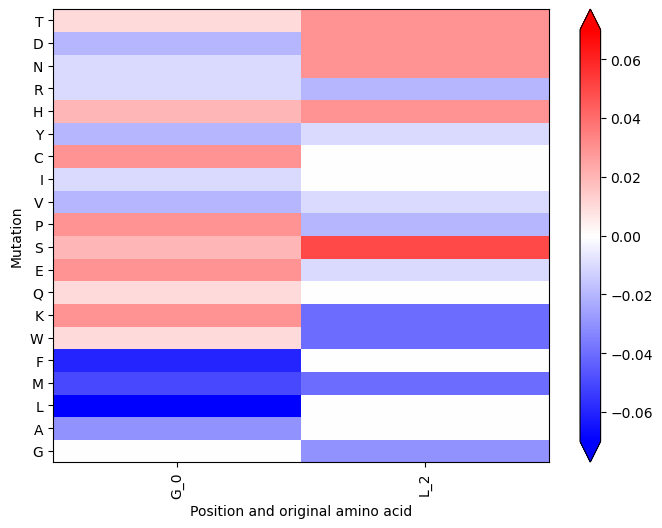

In [38]:
figure = plot_optimization(dats, initial_score, False)

In [57]:
dats

,G_0,L_2
G,0.40,0.37
A,0.37,0.40
L,0.33,0.40
M,0.35,0.36
F,0.34,0.40
W,0.41,0.36
K,0.43,0.36
Q,0.41,0.40
E,0.43,0.39
S,0.42,0.45


In [54]:
difs = dats - initial_score

In [68]:
difs

,G_0,L_2
G,0.00,-0.03
A,-0.03,0.00
L,-0.07,0.00
M,-0.05,-0.04
F,-0.06,0.00
W,0.01,-0.04
K,0.03,-0.04
Q,0.01,0.00
E,0.03,-0.01
S,0.02,0.05


In [59]:
difs.max()

G_0    0.03
L_2    0.05
dtype: float64

In [60]:
top10 = pd.DataFrame(columns=["Position","Mutation","Prediction_Change","Target_Probability"])

In [63]:
difs_copy = difs.copy()

In [65]:
max_vals = difs_copy.max()

In [93]:
prob_change = dats - initial_score
top10 = pd.DataFrame(columns=["Position","Mutation","Prob_increase","Target_probability"])

i = 0

while i < 10 and pred_increase > 0:
    # get column with maximum value
    position_mut = prob_change.max().idxmax()
    mutation = prob_change.idxmax()[position_mut]
    pred_increase = prob_change.loc[mutation, position_mut]
    prob_value = dats.loc[mutation, position_mut]
    prob_change.loc[mutation, position_mut] = np.nan
    mut_series = pd.Series({"Position": position_mut, "Mutation": mutation,
                            "Prob_increase": pred_increase, "Target_probability": prob_value})
    top10 = top10.append(mut_series, ignore_index=True)
    i += 1

print(top10)

  Position Mutation  Prob_increase  Target_probability
0      L_2        S           0.05                0.45
1      G_0        K           0.03                0.43
2      G_0        E           0.03                0.43
3      G_0        P           0.03                0.43
4      G_0        C           0.03                0.43
5      L_2        H           0.03                0.43
6      L_2        N           0.03                0.43
7      L_2        D           0.03                0.43
8      L_2        T           0.03                0.43
9      G_0        S           0.02                0.42


In [96]:
def top_mutations(mutated_scores, initial_score, top_results):

    if type(top_results) != int:
        raise TypeError('top results should be an integer')
    else:
        pass
    
    prob_change = mutated_scores - initial_score

    top_res = pd.DataFrame(columns=["Position","Mutation","Prob_increase","Target_probability"])

    i = 0

    while i < top_results and pred_increase > 0:
        # get column with maximum value
        position_mut = prob_change.max().idxmax()
        # get row with maximum value
        mutation = prob_change.idxmax()[position_mut]
        pred_increase = prob_change.loc[mutation, position_mut]
        prob_value = dats.loc[mutation, position_mut]
        # change it for nan so that we can look for next result
        prob_change.loc[mutation, position_mut] = np.nan
        mut_series = pd.Series({"Position": position_mut, "Mutation": mutation,
                                "Prob_increase": pred_increase, "Target_probability": prob_value})
        top_res = top10.append(mut_series, ignore_index=True)
        i += 1

    return top_res

In [105]:

def test_top_mutations():
    sequence = 'ALIENSRCMING'
    organism = 'human'
    target_loc = 'membrane'
    position = '1,3'

    mutated_scores, initial_score =  optimize_sequence(sequence, organism, target_loc, False, position)
    try:
        top_mutations(mutated_scores, initial_score, "aaat")
    except Exception as exep:
        assert isinstance(exep, TypeError), "Passing a non-integer as top_results did not return a type error"

    result = top_mutations(mutated_scores, initial_score, 10)
    assert type(result) == pd.DataFrame, "The result of top_mutations is not a DataFrame"

In [106]:
test_top_mutations()

UnboundLocalError: local variable 'pred_increase' referenced before assignment

## other options

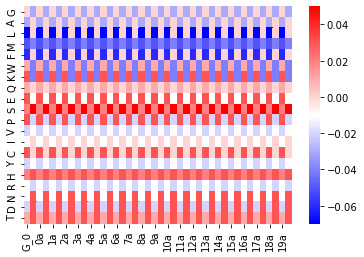

In [30]:
sns.heatmap(dats-initial_score, annot=False, cmap='bwr')
plt.show()

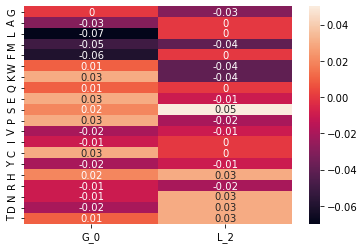

In [15]:
sns.heatmap(dats-initial_score, annot=True)
plt.show()

In [16]:
data2 = dats

In [17]:
for i in range(0,20):
    data2[str(i)+'a'] = dats['G_0']
    data2[str(i)+'b'] = dats['L_2']

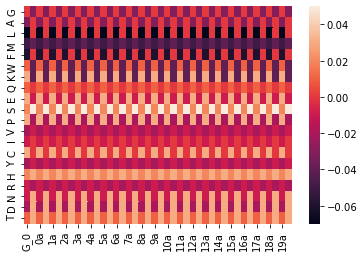

In [18]:
sns.heatmap(data2-initial_score, annot=False)
plt.show()

Other heatmaps:

- https://stackoverflow.com/questions/23994020/colorplot-that-distinguishes-between-positive-and-negative-values
- https://matplotlib.org/2.0.2/examples/pylab_examples/custom_cmap.html

In [19]:
import matplotlib.colors as colors

<ipython-input-31-2ad4584c424d>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(data2.columns, data2.index, data2.values-initial_score,


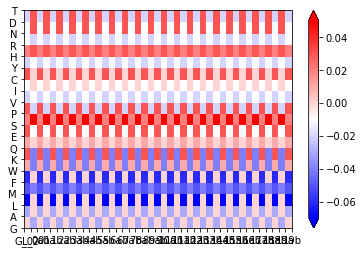

In [31]:
fig, ax = plt.subplots(1, 1)

pcm = ax.pcolormesh(data2.columns, data2.index, data2.values-initial_score,
                       cmap='bwr')
fig.colorbar(pcm, ax=ax, extend='both')

plt.show()

In [43]:
np.max(np.abs(data2.values))

0.45

### Best cMap

<ipython-input-49-3fc1b06c1af4>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(data2.columns, rotation=90)


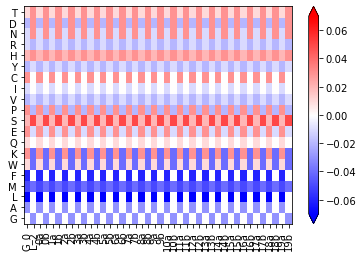

In [49]:
fig, ax = plt.subplots(1, 1)

# take the max o min, whichever is larger

pcm = ax.pcolormesh(data2.columns, data2.index, data2.values-initial_score,shading='nearest',
                       norm=colors.Normalize(vmin=-np.max(np.abs(data2.values-initial_score)), vmax=np.max(np.abs(data2.values-initial_score))),
                       cmap='bwr')
fig.colorbar(pcm, ax=ax, extend='both')
# ax.set_xticklabels(labels, rotation=45, ha='right')
# ax.set_xticklabels(ax.get_xticks(), rotation=90)
ax.set_xticklabels(data2.columns, rotation=90)

plt.show()

<ipython-input-32-4e055d8072b7>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax.pcolormesh(data2.columns, data2.index, data2.values-initial_score,


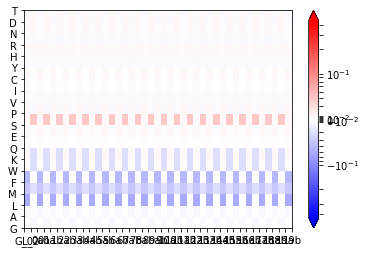

In [32]:
fig, ax = plt.subplots(1, 1)

pcm = ax.pcolormesh(data2.columns, data2.index, data2.values-initial_score,
                       norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-np.max(data2.values), vmax=np.max(data2.values), base=10),
                       cmap='bwr')
fig.colorbar(pcm, ax=ax, extend='both')

plt.show()

<ipython-input-21-de7e5f6b2dc8>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax[0].pcolormesh(data2.columns, data2.index, data2.values,
<ipython-input-21-de7e5f6b2dc8>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = ax[1].pcolormesh(data2.columns, data2.index, data2.values, cmap='RdBu_r', vmin=-np.max(data2.values))


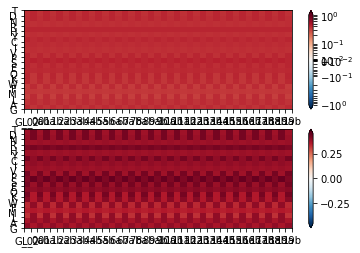

In [21]:
fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolormesh(data2.columns, data2.index, data2.values,
                       norm=colors.SymLogNorm(linthresh=0.03, linscale=0.03,
                                              vmin=-1.0, vmax=1.0, base=10),
                       cmap='RdBu_r')
fig.colorbar(pcm, ax=ax[0], extend='both')

pcm = ax[1].pcolormesh(data2.columns, data2.index, data2.values, cmap='RdBu_r', vmin=-np.max(data2.values))
fig.colorbar(pcm, ax=ax[1], extend='both')
plt.show()

In [ ]:
# loading the model does not cost. Unirep is the slowest part.

In [ ]:
def optimize_sequence_2(sequence, organism, target_class, include_dg=False, positions=None):
    """
    
    """
    # First, find the initial class and initial secretion score for that class
    initial_class, initial_score = secretion_score(sequence, organism, target_class, include_dg)
    # Also find the probability of being from the target_class
#     print('The initial sequence is:', sequence)
#     print('The initial localization clas is:', initial_class)
#     print('The initial probability of being in the secreted class is:', 
#         initial_score)
    
    model_human = pickle.load(open(os.path.join(current_wd,"models","human.pkl"), 'rb'))
    model_yeast = pickle.load(open(os.path.join(current_wd,"models","yeast.pkl"), 'rb'))
    model_ecoli = pickle.load(open(os.path.join(current_wd,"models","ecoli.pkl"), 'rb'))
    
    if include_dg:
        model_dict = {
            'human': model_human,
            'yeast': model_yeast,
            'ecoli': model_ecoli
        }
    else: 
        model_dict = {
            'human': model_human,
            'yeast': model_yeast,
            'ecoli': model_ecoli
        }

    # Access the specific organism model
    model = model_dict[organism]
    
    
    # if no position was specified mutate all
    if positions == None:
        res_poses = np.array(list(range(0,len(sequence))))
    else:
        # create test to check if position is a list
        res_poses = get_residue_positions(positions)
        # inform user that positions are 1 based so that they can usually work on that from a pdb file
        # convert positions to 0 based positions
        res_poses = res_poses - 1
        
        # check if largest position is within the protein length
        if np.max(res_poses)+1 > len(sequence):
            raise ValueError('You passed residue position '+str(np.max(res_poses)+1)+', which is larger than the protein length of '+str(len(sequence))+' residues.')
        else:
            pass

    mutated_scores = pd.DataFrame()
    
    classes = list(model.classes_)
    for resid in res_poses:
#         print("running position", resid, "of", str(np.max(res_poses)))
        
        mut_score_pos = []
        
        for mutation in amino_acids:
            mutated_seq = sequence[:resid] + str(mutation) + sequence[resid+1:]
#             pred_score = 3

            values = get_UniReps(sequence)[0] # do we need this [0]?
            if include_dg:
                dg = calculate_transmembrane_dg(sequence)
                values.append(dg)
            values = values.reshape(1, -1)

                
                # Grab the probabilities from the model
            prediction_probabilities = list(model.predict_proba(values)[0])
                # Returns probability of being secreted class
            pred_score = prediction_probabilities[classes.index(target_class)]
    
    
#             pred_class, pred_score = secretion_score(mutated_seq, organism, target_class, include_dg)
            mut_score_pos.append(pred_score)
        
        mut_score_pos = pd.Series(mut_score_pos, index = amino_acids)
        
        original_name = str(sequence[resid]) + '_' + str(resid)
        
        mutated_scores[original_name] = mut_score_pos

    return mutated_scores

In [ ]:
%timeit optimize_sequence_2(seq, org, target, positions=['1','3'])

In [ ]:
%timeit optimize_sequence(seq, org, target, positions=['1','3'])

In [ ]:
%timeit get_UniReps(sequence)[0]

In [ ]:
# wrapper function
def optimize_sequence(seq, target_class, organism, include_dg=False, position=None):
    """
    
    """
    # First, find the initial class and initial secretion score for that class
    initial_class, initial_score = secretion_score(seq, organism, target_class, include_dg)
    # Also find the probability of being from the target_class
    print('The initial sequence is:', sequence)
    print('The initial localization clas is:', initial_class)
    print('The initial probability of being in the secreted class is:', 
        initial_score)


In [ ]:
def secretion_optimization(sequence, organism, position, include_dg=False):
    """
    Introduces amino acid point mutation at given position to improve
    probability of given sequence to be part of the secreted class

    Args:
        sequence (str): amino acid sequence in single-letter format
        organism (str): specific organism of sequence type 
                        (all, human, yeast, ecoli)
        position (int): given position where point mutations can occur
                        (where first residue is position 0)
        include_dg (Boolean): specify inclusion of additional features
                                (default=False)

    Returns:
        sequence (str): mutated amino acid sequence
        point_mutation_dict (dict): dictionary of point mutation amino acid
                                    and secretion score
    """
    # First, find the initial class and initial secretion score
    initial_class, initial_score = secretion_score(sequence, organism, include_dg)
    print('The initial sequence is:', sequence)
    print('The initial localization clas is:', initial_class)
    print('The initial probability of being in the secreted class is:', 
        initial_score)

    # Set up point mutations
    mutated_scores_list = []
    for residue in amino_acids:
        sequence_list = list(sequence)
        sequence_list[position] = residue
        mutated_sequence = "".join(sequence_list)
        mutated_class, mutated_score = secretion_score(
            sequence, organism, include_dg)
        mutated_scores_list.append(mutated_score)
        # Replace initial sequence if mutated secretion score is better
        if mutated_score > initial_score:
            sequence = mutated_sequence
            initial_score = mutated_score
            initial_class = mutated_class

    print('The mutated sequence is:', sequence)
    print('The mutated class is:', initial_class)
    print('The mutated probability of being in the secreted class is:',
        mutated_score)

    # Plot point mutations and scores
    plt.plot(amino_acids, mutated_scores_list)
    plt.xlabel('Amino Acid Point Mutation at Position %d' % position)
    plt.ylabel('Probability of Secretion Class')

    # Create dictionary of point mutations and scores
    point_mutation_dict = {amino_acids[i]: mutated_scores_list[i]
        for i in range(len(amino_acids))}

    return sequence, point_mutation_dict


In [ ]:
def secretion_optimization_all_positions(sequence, organism):
    """
    create ssm like representation
    """


def optimize_secretion(sequence, organism, position):
    """
    Wrapper function.

    It would be great if we added a parameter position that can take in a list of positions
    so the user is free to mutate only one position or a few positions of the sequence. 
    If nothing is passed, we mutate all sequence.

    """

